In [394]:
import pandas as pd
import seaborn as sb
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import sklearn.tree as tree
import matplotlib.pyplot as plt
import numpy as np


In [395]:
def split_data(df):
    # Filter the rows based on the 'confID_EA' and 'confID_EW' values
    confEA_data = df[df['confID_EA'] == 1]
    confEW_data = df[df['confID_WE'] == 1]

    return confEA_data, confEW_data
    

In [396]:
df_teams=pd.read_csv('data_merged.csv')
df_teams = df_teams[df_teams['year'] != 1]
df_teams.drop(columns=['tmID'], inplace=True)
df_teams.head()


,year,rank,playoff,o_fgm,o_fga,o_ftm,o_fta,o_3pm,o_3pa,o_oreb,...,dq,height,weight,award_count,won,lost,post_wins,post_losses,W,L
16,2,0.0,1,812.0,1903.0,431.0,577.0,131.0,386.0,305.0,...,6.0,71.500000,164.416667,0.0,9.0,23.0,0.0,0.0,0.0,0.0
17,2,1.0,1,809.0,1828.0,426.0,570.0,141.0,407.0,331.0,...,7.0,71.866667,170.933333,0.0,17.0,15.0,3.0,3.0,3.0,3.0
18,2,0.0,0,868.0,1980.0,519.0,699.0,76.0,273.0,341.0,...,2.0,71.833333,164.583333,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,2,1.0,1,891.0,1894.0,521.0,634.0,172.0,491.0,273.0,...,2.0,71.909091,167.636364,0.0,27.0,5.0,6.0,0.0,6.0,0.0
20,2,0.0,0,796.0,1838.0,428.0,569.0,193.0,521.0,285.0,...,9.0,71.923077,166.769231,0.0,0.0,0.0,0.0,0.0,0.0,0.0


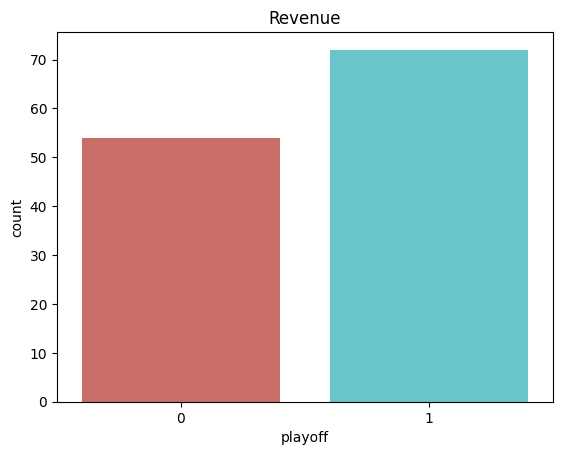

In [397]:
sb.countplot(x='playoff',data=df_teams, palette='hls')
plt.title("Revenue")
plt.show()

In [398]:
from sklearn.decomposition import PCA

def split_and_train(year, model, data, target_col="playoff", scaling=False):
        # Split the data into training and test sets
        train_data = data[data["year"] < year ]
        test_data = data[data["year"] == year ]


        if(scaling):
            scaler = MinMaxScaler()
            train_data = scaler.fit_transform(train_data)
            train_data = pd.DataFrame(train_data, columns=data.columns)
            test_data = scaler.transform(test_data)
            test_data = pd.DataFrame(test_data, columns=data.columns)


        X_train = train_data.drop([target_col], axis=1)
        y_train = train_data[target_col]
        X_test = test_data.drop([target_col], axis=1)
        y_test = test_data[target_col]

        #PCA
        # pca = PCA(n_components=28, svd_solver='full')
        # X_train = pca.fit_transform(X_train)
        # X_test = pca.transform(X_test)

        # Create and train the decision tree model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        #y_pred = model.predict(X_test)
        # Make probability predictions on the test set
        # Sort the probabilities in reverse order and get the indices
        y_prob = model.predict_proba(X_test)
        sorted_indices = np.argsort(-y_prob[:, 1])
        print(sorted_indices)

        # Set the top 4 predictions with target 1 and others with target 0
        y_pred = np.zeros_like(y_test)
        y_pred[sorted_indices[:4]] = 1
        
        result_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 'y_prob': y_prob[:, 1]})
        result_df.to_csv("hi.csv", index=False)


    

        return y_test, y_pred
        


def train_evaluate_decision_tree_graph(model, data, target_col="playoff", scaling=False):
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    years_tested = []

    # Sort the data by the "year" column
    data = data.sort_values(by="year")
    data1, data2 = split_data(data)
    years = sorted(data["year"].unique())

    for year in years[4:]:
       
        y_test1, y_pred1 = split_and_train(year, model, data1, target_col, scaling)
        y_test2, y_pred2 = split_and_train(year, model, data2, target_col, scaling)
        # Merge of 
        # Join y_test1 and y_test2
        y_test = np.concatenate([y_test1, y_test2])

        # Join y_pred1 and y_pred2
        y_pred = np.concatenate([y_pred1, y_pred2])


        # Calculate accuracy and precision
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        years_tested.append(year)
        

    return years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores


In [399]:
def plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores):
    # Create a graph to plot accuracy, precision, recall, and f1 over time
    plt.figure(figsize=(20, 5))

    # Plot accuracy
    plt.subplot(1, 4, 1)
    plt.plot(years_tested, accuracy_scores, marker='o')
    plt.title('Accuracy Over Time')
    plt.xlabel('Test Year')
    plt.ylabel('Accuracy')

    # Plot precision
    plt.subplot(1, 4, 2)
    plt.plot(years_tested, precision_scores, marker='o', color='orange')
    plt.title('Precision Over Time')
    plt.xlabel('Test Year')
    plt.ylabel('Precision')

    # Plot recall
    plt.subplot(1, 4, 3)
    plt.plot(years_tested, recall_scores, marker='o', color='green')
    plt.title('Recall Over Time')
    plt.xlabel('Test Year')
    plt.ylabel('Recall')

    # Plot f1
    plt.subplot(1, 4, 4)
    plt.plot(years_tested, f1_scores, marker='o', color='red')
    plt.title('F1 Over Time')
    plt.xlabel('Test Year')
    plt.ylabel('F1')

    plt.tight_layout()
    plt.show()
    
    # Calculate means
    accuracy_mean = sum(accuracy_scores) / len(accuracy_scores)
    precision_mean = sum(precision_scores) / len(precision_scores)
    recall_mean = sum(recall_scores) / len(recall_scores)
    f1_mean = sum(f1_scores) / len(f1_scores)

    print("Accuracy: ", accuracy_mean)
    print("Precision: ", precision_mean)
    print("Recall: ", recall_mean)
    print("F1: ", f1_mean)


[1 3 4 0 2 5]
[1 3 4 5 0 2 6]
[0 2 3 4 5 6 1]
[0 2 5 6 1 3 4]
[1 2 3 4 5 0]
[0 2 4 5 6 1 3]
[1 2 3 4 0 5 6]
[0 1 2 3 4 5 6]
[2 3 0 1 4 5 6]
[0 2 3 4 5 1]


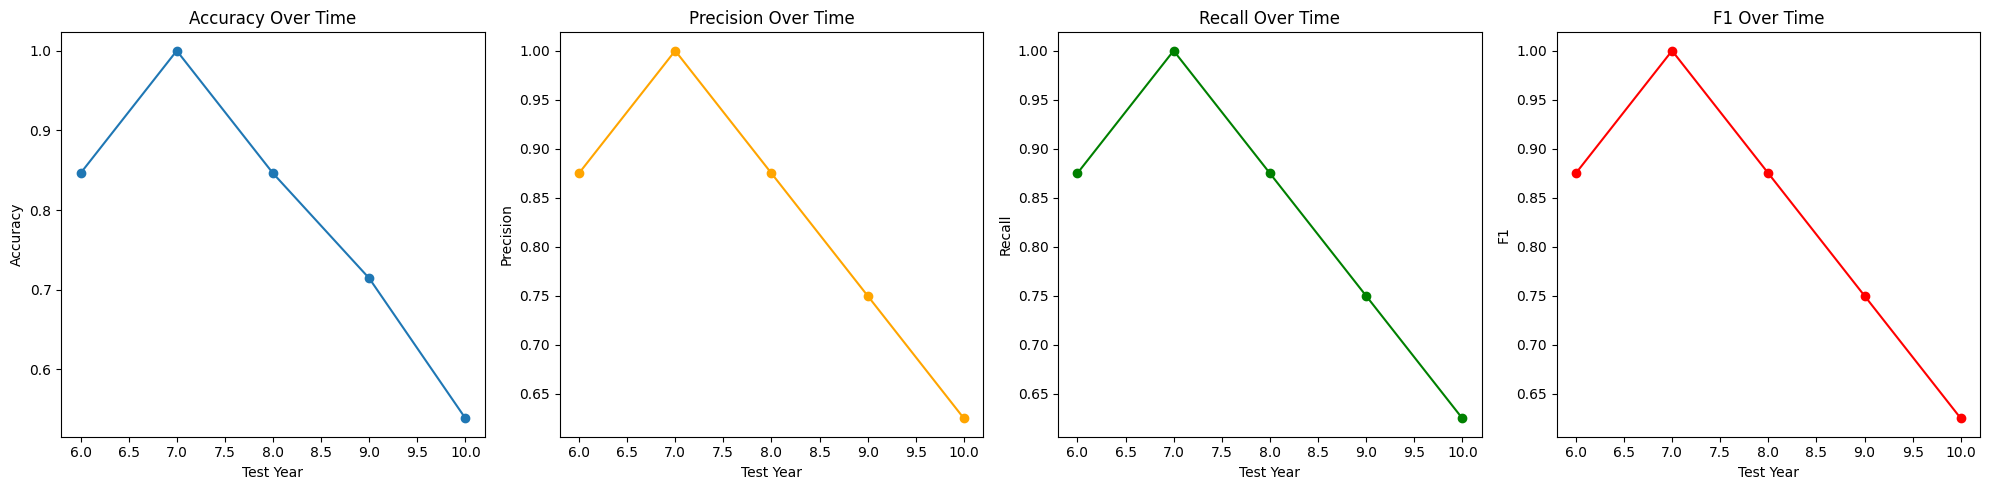

Accuracy:  0.7890109890109891
Precision:  0.825
Recall:  0.825
F1:  0.825


In [400]:
model = DecisionTreeClassifier()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams)
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)

[4 3 1 0 2 5]
[5 1 3 4 6 2 0]
[4 2 5 0 3 1 6]
[0 5 2 6 3 4 1]
[3 4 2 0 1 5]
[4 0 6 5 2 1 3]
[3 2 4 1 6 5 0]
[0 4 6 1 2 3 5]
[2 3 0 4 6 1 5]
[2 4 0 5 1 3]


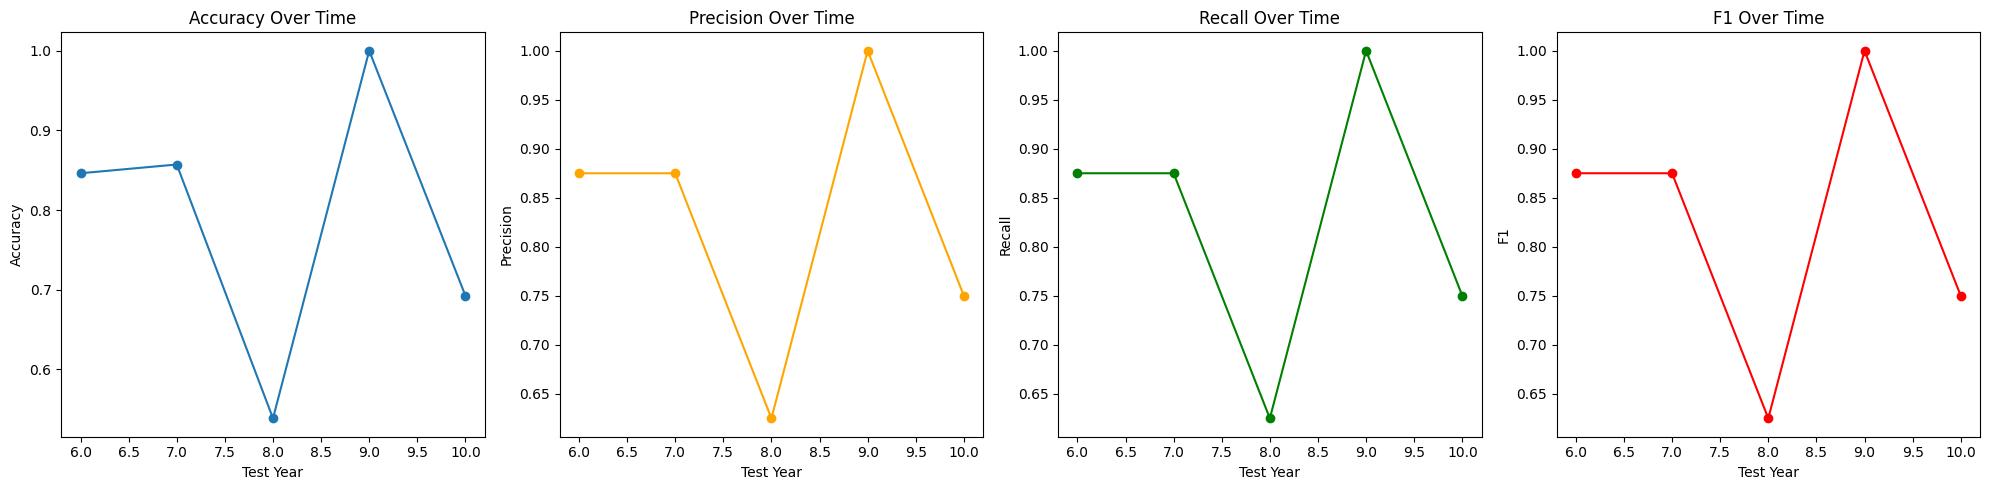

Accuracy:  0.7868131868131869
Precision:  0.825
Recall:  0.825
F1:  0.825


In [401]:
model = RandomForestClassifier()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams)
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)

[4 1 3 0 2 5]
[5 3 4 1 0 6 2]
[4 5 0 1 2 6 3]
[2 0 5 6 3 1 4]
[3 4 1 2 5 0]
[4 0 6 5 1 2 3]
[3 4 1 6 5 0 2]
[4 0 1 6 2 3 5]
[2 3 5 0 4 1 6]
[0 5 2 4 1 3]


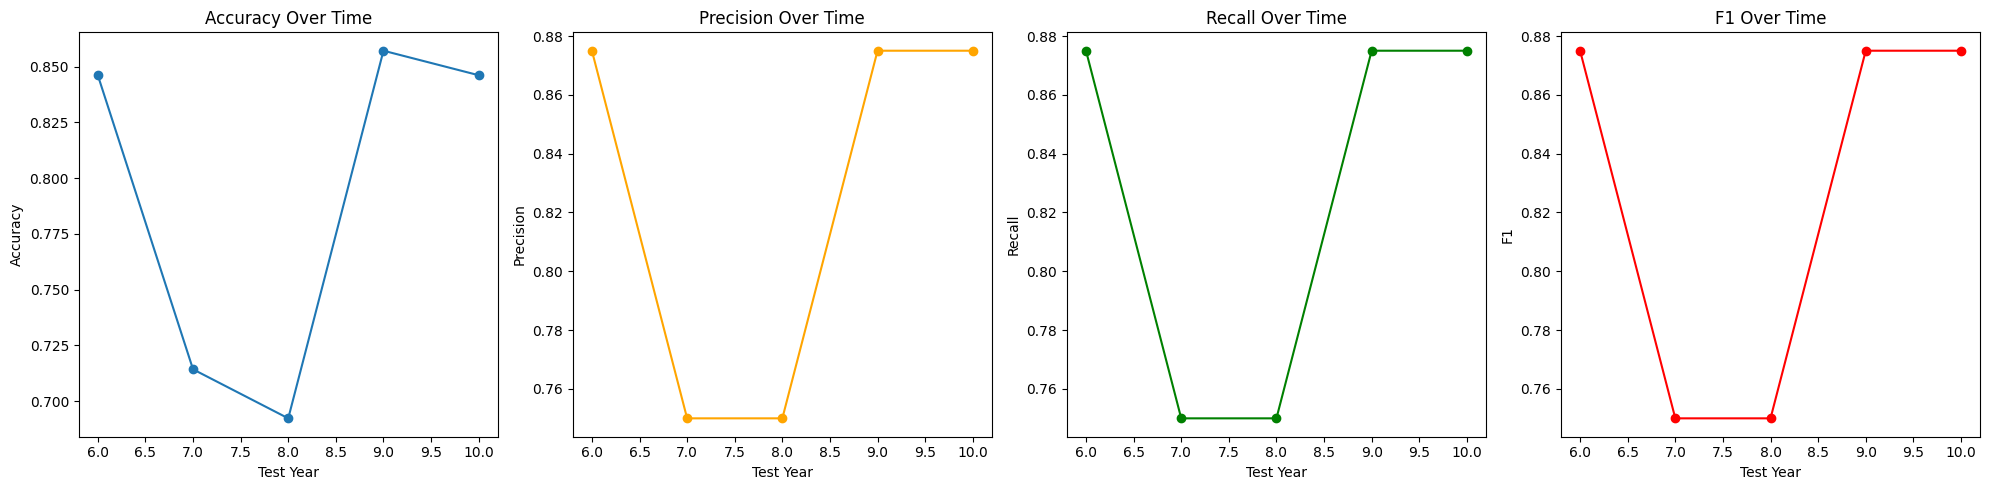

Accuracy:  0.7912087912087913
Precision:  0.825
Recall:  0.825
F1:  0.825


In [402]:
model = KNeighborsClassifier()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams, scaling=True)
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)

[4 1 3 0 5 2]
[5 1 4 3 6 2 0]
[4 3 2 0 5 6 1]
[5 6 2 0 3 4 1]
[4 3 2 1 5 0]
[0 4 6 5 2 3 1]
[4 1 3 2 0 5 6]
[0 6 4 1 2 5 3]
[2 3 5 4 0 6 1]
[4 2 0 5 3 1]


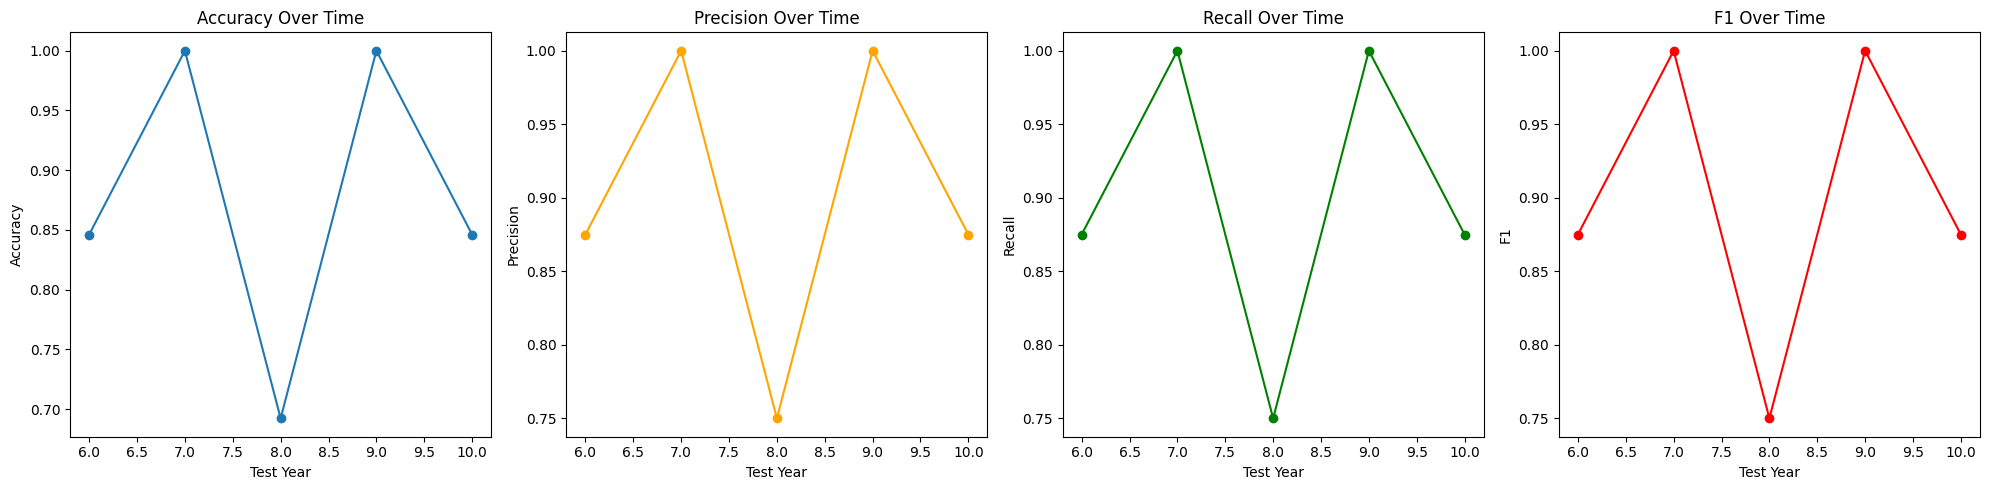

Accuracy:  0.8769230769230768
Precision:  0.9
Recall:  0.9
F1:  0.9


In [403]:
model = XGBClassifier()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams)
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)


[3 4 0 1 2 5]
[1 3 4 5 6 0 2]
[3 5 4 1 0 2 6]
[0 2 5 6 3 4 1]
[3 4 2 0 1 5]
[0 4 6 5 2 1 3]
[3 2 4 0 1 5 6]
[4 6 0 1 5 3 2]
[2 3 0 1 4 6 5]
[0 4 5 1 2 3]


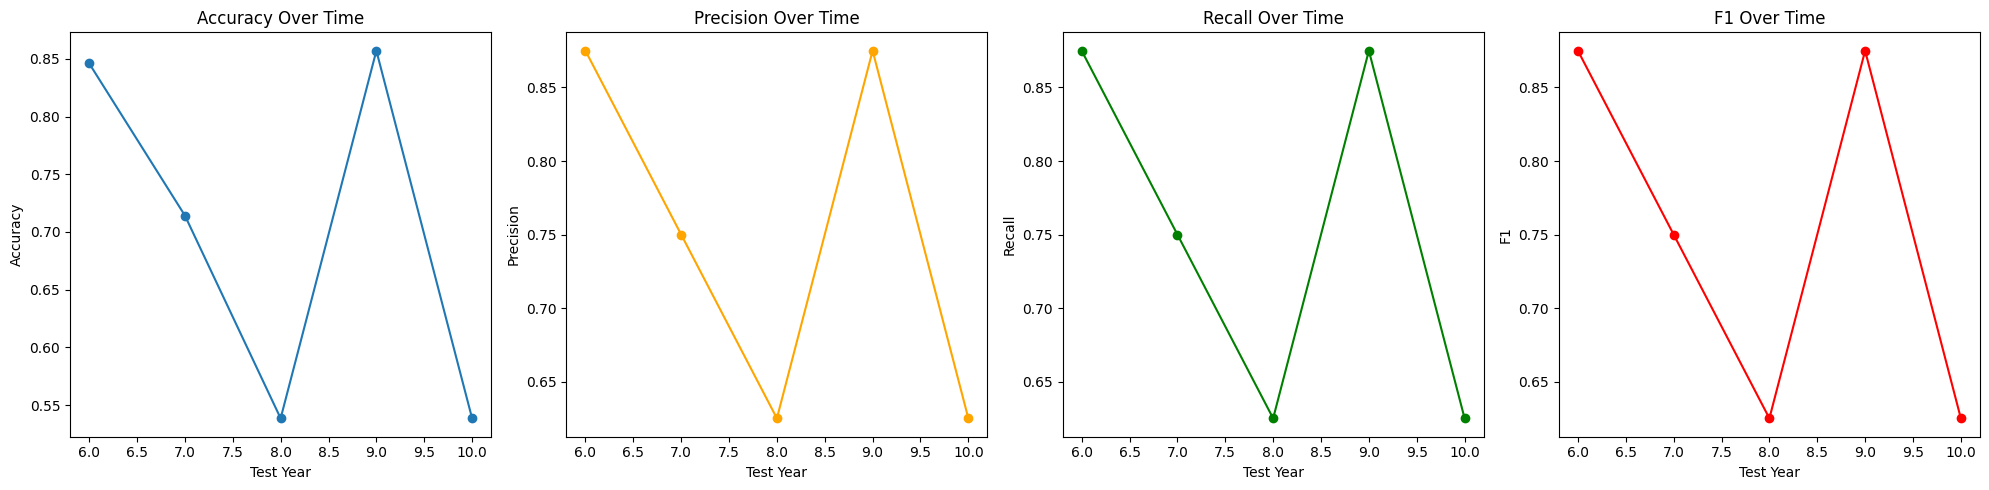

Accuracy:  0.6989010989010989
Precision:  0.75
Recall:  0.75
F1:  0.75


In [404]:
model = GaussianNB()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams)
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)

In [405]:
model =SVC()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams, scaling=True)
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)

AttributeError: predict_proba is not available when  probability=False

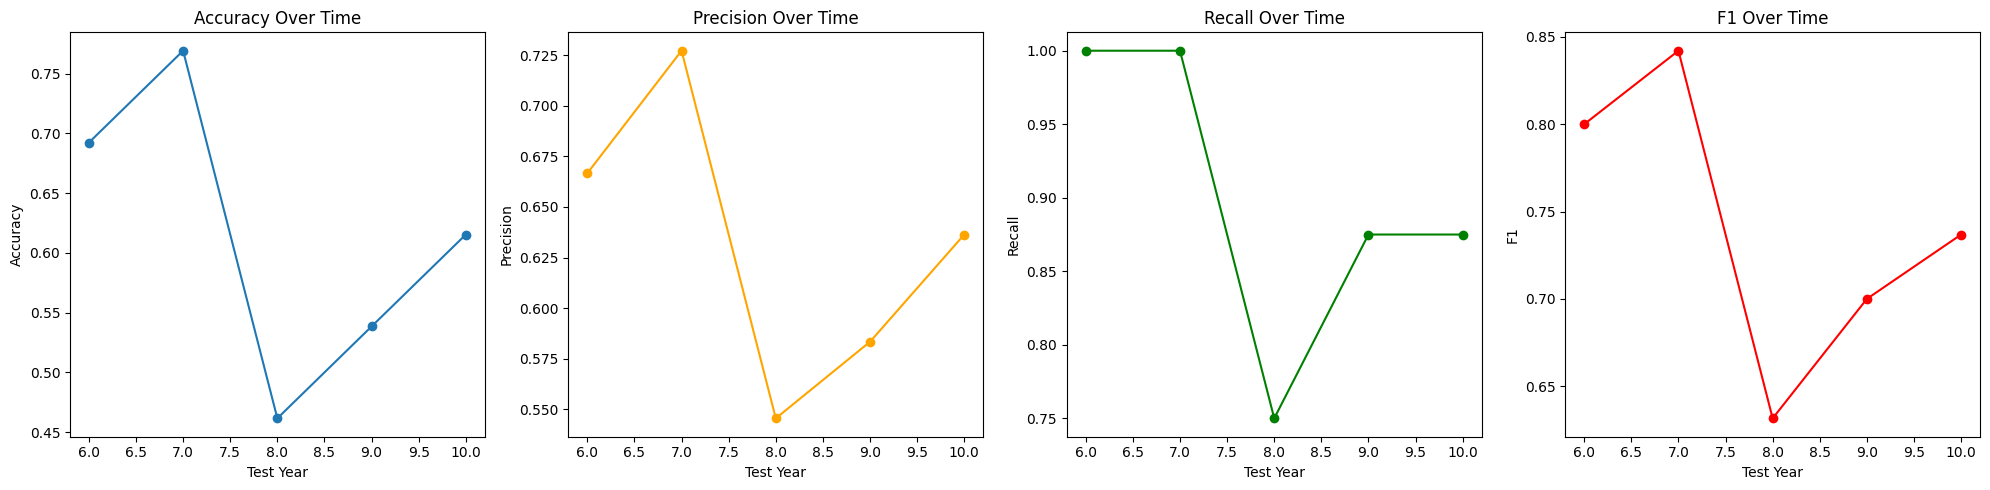

Accuracy:  0.6153846153846154
Precision:  0.6318181818181818
Recall:  0.9
F1:  0.7421052631578948


In [ ]:
model = LogisticRegression()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams, scaling=True)
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)

C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


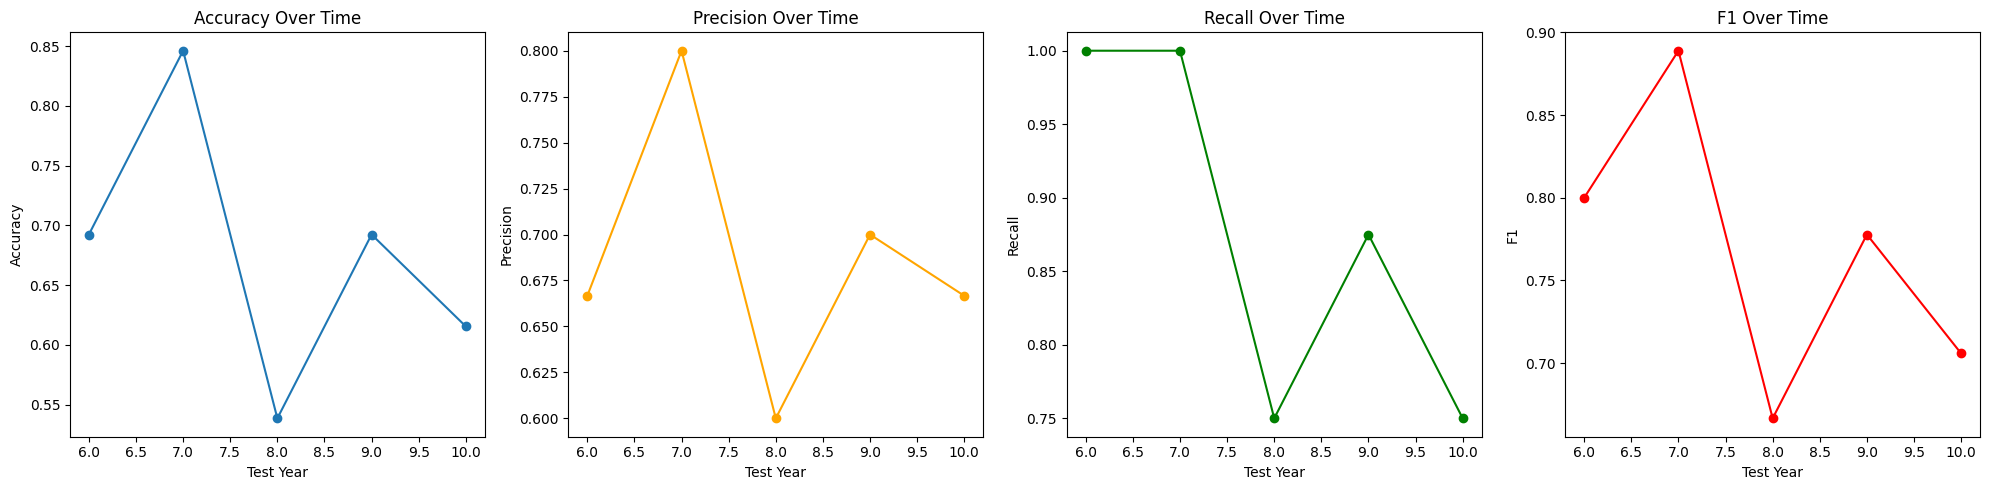

Accuracy:  0.676923076923077
Precision:  0.6866666666666666
Recall:  0.875
F1:  0.7678431372549019


In [ ]:
model = MLPClassifier()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams, scaling=True)
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)